In [14]:
#Prints the Python path. You want it to end with .../SC VOT Analysis/vot-env/bin/python so you know the right environment is in use.

import sys
print(sys.executable)  # should end with .../SC VOT Analysis/vot-env/bin/python

/Users/yeshej/Desktop/SC VOT Analysis/vot-env/bin/python3.12


In [15]:
# Brings in librosa (audio), soundfile (metadata), matplotlib (plots), pandas (tables). 
# Also creates results/figures/ so your plots save somewhere predictable.

from pathlib import Path
import numpy as np
import pandas as pd
import soundfile as sf

import librosa
import librosa.display
import matplotlib.pyplot as plt

# where to save figures/outputs
FIG_DIR = Path("results/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [16]:
# You tell the notebook where your .wav live. It gathers all files and prints a short list.
# What to check: you see the correct folder and a non-zero number of files.


# EITHER the folder you currently have:
RAW_DIR = Path("Cooper Data/SECpataka_2025-08-13")

# OR, if/when you move files to the recommended structure:
# RAW_DIR = Path("data/raw")

assert RAW_DIR.exists(), f"RAW_DIR not found: {RAW_DIR.resolve()}"
wav_files = sorted(RAW_DIR.glob("*.wav"))
assert len(wav_files) > 0, f"No .wav files found in {RAW_DIR}"

print(f"Using RAW_DIR = {RAW_DIR.resolve()}")
print(f"Found {len(wav_files)} wav files. First 3:")
for f in wav_files[:3]:
    print(" -", f.name)

Using RAW_DIR = /Users/yeshej/Desktop/SC VOT Analysis/Cooper Data/SECpataka_2025-08-13
Found 12 wav files. First 3:
 - 2025-08-13_12-00-00_pataka.wav
 - 2025-08-13_12-01-00_pataka.wav
 - 2025-08-13_12-02-00_pataka.wav


In [17]:
# Builds a DataFrame with: filename, path, sample rate (Hz), duration (s), channels, format.
# What to check: sample rates are consistent (e.g., all 44,100 Hz), durations look plausible, channels typically 1 (mono) for speech tasks.

rows = []
for f in wav_files:
    info = sf.info(str(f))
    rows.append({
        "file": f.name,
        "path": str(f),
        "samplerate_Hz": info.samplerate,
        "duration_s": round(info.frames / info.samplerate, 3),
        "channels": info.channels,
        "format": info.format
    })
meta = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
meta


,file,path,samplerate_Hz,duration_s,channels,format
0,2025-08-13_12-00-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,22.674,1,WAV
1,2025-08-13_12-01-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,22.399,1,WAV
2,2025-08-13_12-02-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,23.099,1,WAV
3,2025-08-13_12-03-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,22.499,1,WAV
4,2025-08-13_12-04-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,21.874,1,WAV
5,2025-08-13_12-05-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,21.249,1,WAV
6,2025-08-13_12-06-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,21.249,1,WAV
7,2025-08-13_12-08-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,21.624,1,WAV
8,2025-08-13_12-09-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,24.599,1,WAV
9,2025-08-13_12-10-00_pataka.wav,Cooper Data/SECpataka_2025-08-13/2025-08-13_12...,44100,23.399,1,WAV


In [18]:
# You choose which file index to preview (0, 1, 2…). Just a selector.

idx = 0  # change to 1, 2, ... to preview different files
preview_path = wav_files[idx]
preview_path


PosixPath('Cooper Data/SECpataka_2025-08-13/2025-08-13_12-00-00_pataka.wav')

Previewing: 2025-08-13_12-00-00_pataka.wav
sr = 44100 Hz | duration = 22.67 s | samples = 999942


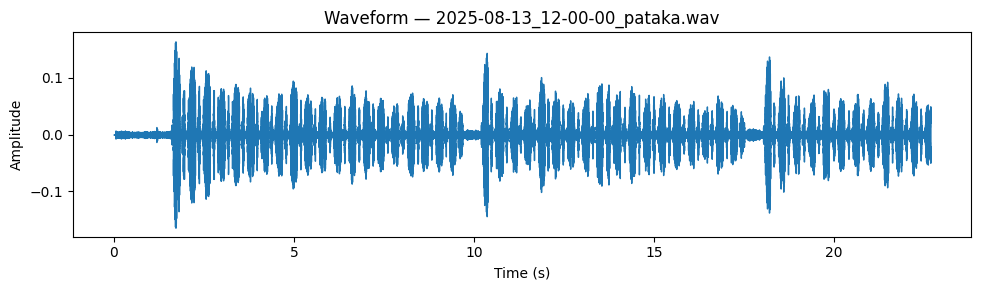

In [19]:
# Cell 5 – waveform (time-domain)
# Loads the audio and plots amplitude vs time (seconds).
# What to check: You see repeated “chunks” for the repeated pa-ta-ka. Vowels look like strong, smooth oscillations; stop closures look near-flat; bursts look like thin spikes.


y, sr = librosa.load(preview_path, sr=None)  # keep native sample rate
print(f"Previewing: {preview_path.name}")
print(f"sr = {sr} Hz | duration = {len(y)/sr:.2f} s | samples = {len(y)}")

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=sr)
plt.title(f"Waveform — {preview_path.name}")
plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
plt.tight_layout(); plt.show()


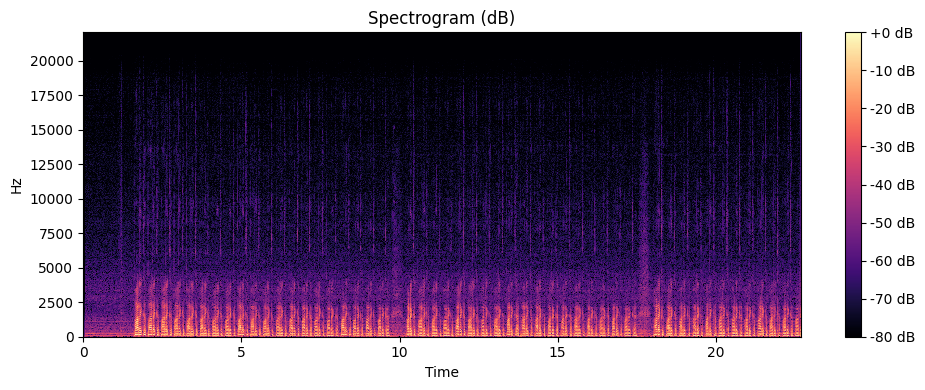

Saved spectrogram to: results/figures/2025-08-13_12-00-00_pataka_spectrogram.png


In [20]:
# Cell 6 – spectrogram (frequency-domain)
# Computes an STFT and displays Time (x) vs Frequency (y) with color = energy in dB. 
# What to check: Bursts = thin vertical bright stripes (broadband energy), Closures = darker low-energy zones before bursts, Voicing/vowels = horizontal bands (formants) and fine vertical “striations” (pitch harmonics).

# Aspiration/noise = noisy energy after burst, before voicing stabilizes.


D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.tight_layout()

out_png = FIG_DIR / f"{preview_path.stem}_spectrogram.png"
plt.savefig(out_png, dpi=150)
plt.show()

print("Saved spectrogram to:", out_png)


Saving wave+spec for first 3 files...


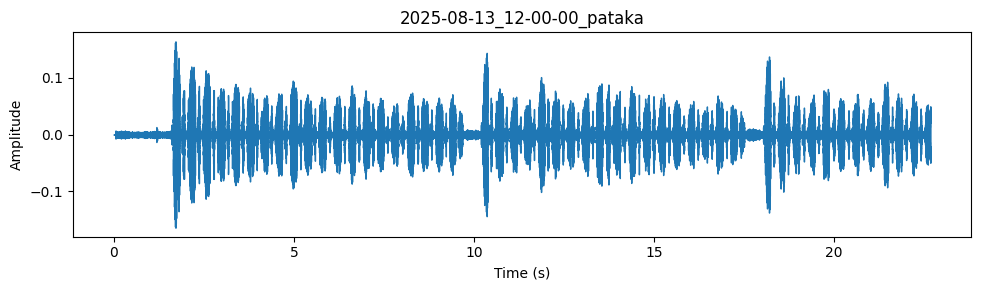

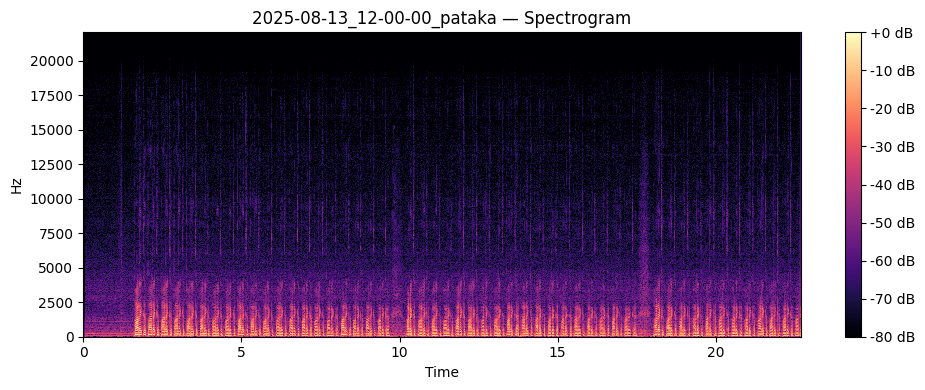

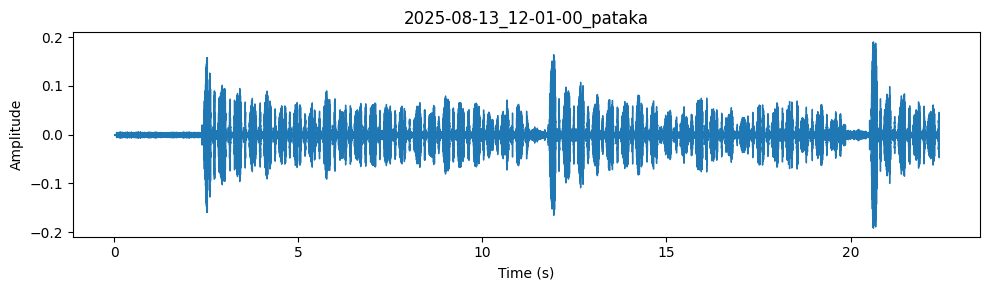

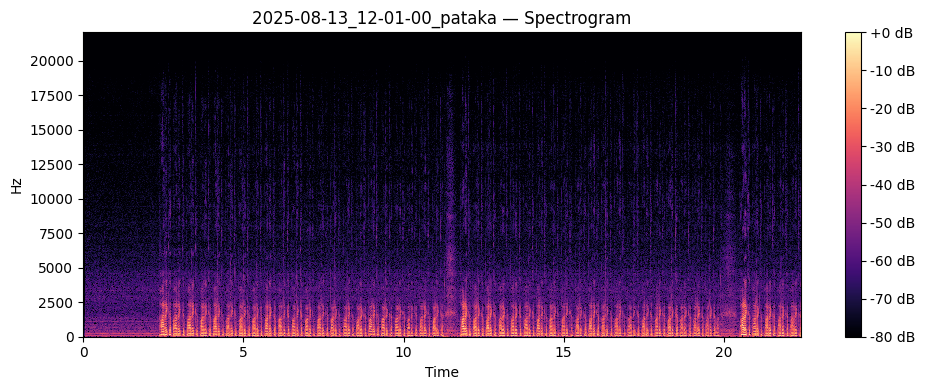

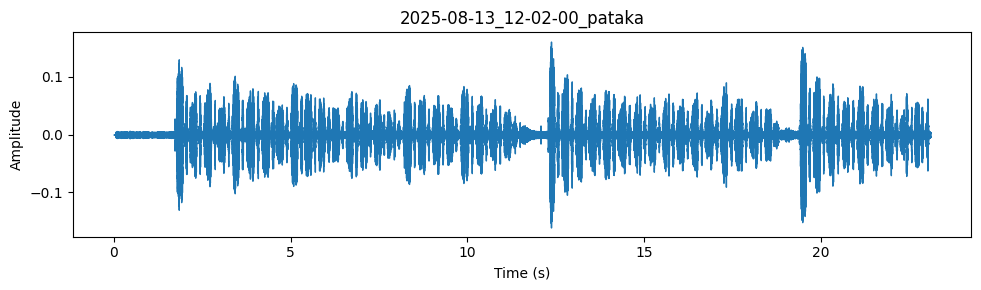

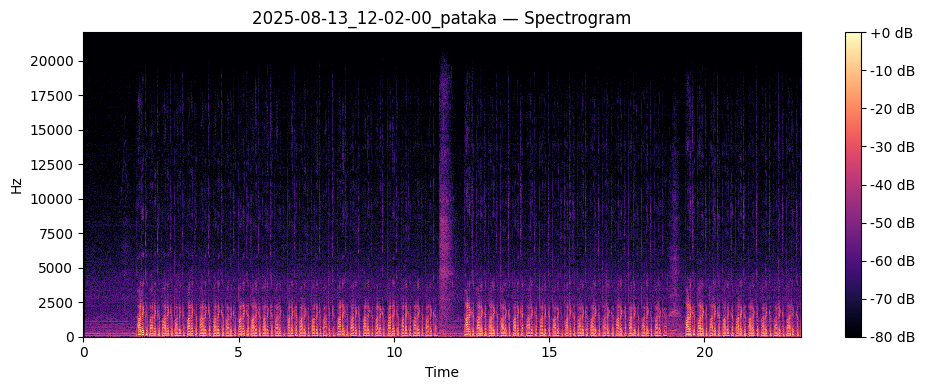

[('2025-08-13_12-00-00_pataka.wav',
  'results/figures/2025-08-13_12-00-00_pataka_wave.png',
  'results/figures/2025-08-13_12-00-00_pataka_spec.png'),
 ('2025-08-13_12-01-00_pataka.wav',
  'results/figures/2025-08-13_12-01-00_pataka_wave.png',
  'results/figures/2025-08-13_12-01-00_pataka_spec.png'),
 ('2025-08-13_12-02-00_pataka.wav',
  'results/figures/2025-08-13_12-02-00_pataka_wave.png',
  'results/figures/2025-08-13_12-02-00_pataka_spec.png')]

In [21]:
# Cell 7 – batch save
# Saves waveform & spectrogram PNGs for the first N files into results/figures/. Great for updates to your mentor.

def save_wave_and_spec(path):
    y, sr = librosa.load(path, sr=None)
    stem = Path(path).stem

    # waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(stem); plt.xlabel("Time (s)"); plt.ylabel("Amplitude")
    plt.tight_layout()
    out_wave = FIG_DIR / f"{stem}_wave.png"
    plt.savefig(out_wave, dpi=150); plt.show()

    # spectrogram
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB"); plt.title(f"{stem} — Spectrogram")
    plt.tight_layout()
    out_spec = FIG_DIR / f"{stem}_spec.png"
    plt.savefig(out_spec, dpi=150); plt.show()

    return str(out_wave), str(out_spec)

N = min(3, len(wav_files))  # change N if you want more
print(f"Saving wave+spec for first {N} files...")
saved = []
for f in wav_files[:N]:
    saved.append((f.name,) + save_wave_and_spec(str(f)))
saved

In [22]:
# Cell 8 – save metadata to CSV
# Writes results/audio_metadata.csv. Handy as a lightweight manifest of what you processed.

meta_csv = Path("results") / "audio_metadata.csv"
meta_csv.parent.mkdir(exist_ok=True)
meta.to_csv(meta_csv, index=False)
print("Saved:", meta_csv.resolve())


Saved: /Users/yeshej/Desktop/SC VOT Analysis/results/audio_metadata.csv
